In [56]:
# importando as bibliotecas 

import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import zipfile as zp
import io
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap as lsc
import matplotlib.ticker as mticker

import pandas as pd

# importando arquivos 
# URL do arquivo ZIP para mapa coroplético
url = "http://www.usp.br/nereus/wp-content/uploads/BR_UF_2021.zip"

# Fazer o download do arquivo ZIP e extrair seu conteúdo
response = rq.get(url)
zip_file = zp.ZipFile(io.BytesIO(response.content))
zip_file.extractall("/content/brasil_estados_folder")

# Importar o shapefile
brasil_estados = gpd.read_file("/content/brasil_estados_folder/BR_UF_2021.shp")

# importando o DataSet anp meses 5 e 6

gas_eta_5=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-05.csv' ,sep=';')
gas_eta_6=pd.read_csv('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2023/precos-gasolina-etanol-06.csv',sep=';')
gas_eta=pd.concat([gas_eta_5,gas_eta_6])


In [57]:
gas_eta=pd.DataFrame(gas_eta,columns=['Regiao - Sigla','Estado - Sigla','Municipio','Produto','Data da Coleta','Valor de Venda','Bandeira'])

# transformando os dados da coluna valor da venda para float
gas_eta['Valor de Venda']=gas_eta['Valor de Venda'].apply(lambda x: float(x.replace(',','.')))

# transformando os dados de data para datetime
gas_eta['Data da Coleta']=pd.to_datetime(gas_eta['Data da Coleta'],dayfirst=True)


In [58]:
# estados da união 
estados = {"AC": "Acre","AL": "Alagoas","AP": "Amapá","AM": "Amazonas","BA": "Bahia","CE": "Ceará","DF": "Distrito Federal","ES": "Espírito Santo","GO": "Goiás","MA": "Maranhão","MT": "Mato Grosso","MS": "Mato Grosso do Sul","MG": "Minas Gerais","PA": "Pará","PB": "Paraíba","PR": "Paraná","PE": "Pernambuco","PI": "Piauí","RJ": "Rio de Janeiro","RN": "Rio Grande do Norte","RS": "Rio Grande do Sul","RO": "Rondônia","RR": "Roraima","SC": "Santa Catarina","SP": "São Paulo","SE": "Sergipe","TO": "Tocantins"}


In [59]:
siglas_para_regioes = {
    'SE':'Sudeste',
    'S' :'Sul',
    'N' : 'Norte',
    'NE': 'Nordeste',
    'CO': 'Centro-oeste'
}

In [60]:
# trocando o nome de siglas para o nome dos estados
gas_eta['Estado - Sigla']=gas_eta['Estado - Sigla'].apply(lambda x:estados[x])
gas_eta['Regiao - Sigla']=gas_eta['Regiao - Sigla'].apply(lambda x:siglas_para_regioes[x])
gas_eta.rename(columns={'Estado - Sigla':'Estado','Regiao - Sigla':'regiao'},inplace=True)

In [61]:
media_por_estado=gas_eta.pivot_table(columns='Produto',index='Estado',values='Valor de Venda', aggfunc='mean')


In [62]:
# Merge dos dados com as geometrias dos estados
estados_merged = brasil_estados.merge(media_por_estado, left_on='NM_UF', right_on='Estado')

In [69]:
estados_merged.plot(column='GASOLINA', cmap='Oranges', legend=False, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

<Figure size 640x480 with 0 Axes>

In [71]:
def adicionar_rotulos(obj,barras):
    for barra in barras:
        largura = barra.get_width()
        obj.text(largura-0.5, barra.get_y() + barra.get_height() / 2, f'R${largura:.2f}'.replace('.',','), ha='right', va='center', color='white', fontweight='bold',fontsize=15)


NameError: name 'preco_medio_por_estado' is not defined

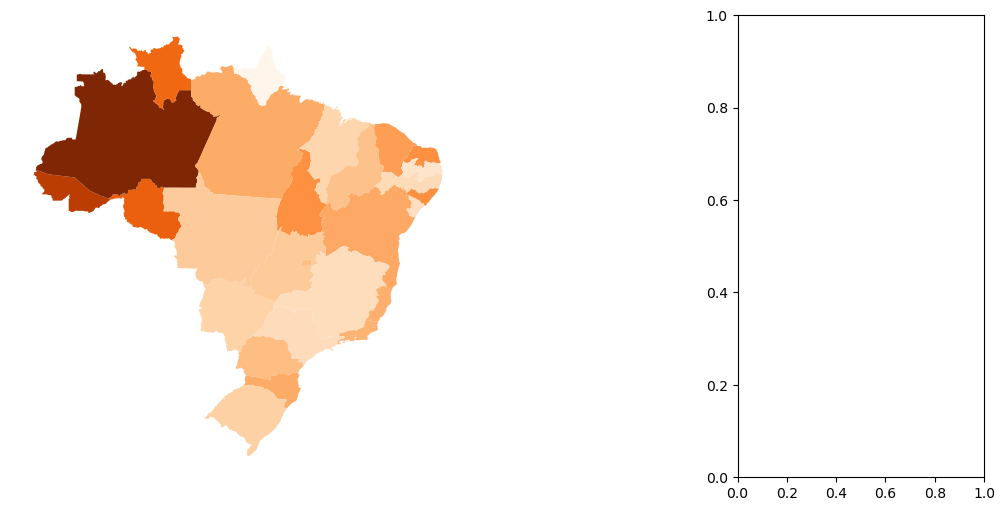

In [70]:
# Criar uma nova figura para Gasolina Aditivada
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [0.6, 0.2]})
# Plotar mapas coropléticos com as cores correspondentes (ajustando tamanho)
estados_merged.plot(column='GASOLINA', cmap='Oranges', legend=False, ax=axes[0])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Plotar gráfico de barras horizontais para Gasolina Aditivada (ajustando tamanho)

# Define a cor gradual usando cmap, começando em red e indo até gray
bar_plot = df_sorted_aditivada.plot(kind='barh', y='GASOLINA', ax=axes[1], color=plt.cm.Oranges(color_values))
axes[1].set_xticks([])

# Remover a legenda do gráfico de barras horizontal
axes[1].get_legend().remove()
axes[1].spines[['top', 'right', 'bottom', 'left']].set_visible(False)

# Adicionar os valores nas barras do gráfico de barras
for p in bar_plot.patches:
    value = f'R${p.get_width():.2f}'  # Formatar valor como preço
    bar_plot.annotate(value, xy=(p.get_width(), p.get_y() + p.get_height() / 2),
                      xytext=(3, 0), textcoords='offset points', color='gray', fontsize=10,
                      verticalalignment='center')

# Adicionar título centralizado
fig.suptitle('Análise do Preço Médio em R$/litro da Gasolina Aditivada por Estado', fontsize=20, fontweight='bold', color='maroon',fontstyle= 'italic', ha='center')

# Remover o título do eixo y do gráfico de barras
bar_plot.set_ylabel('')

# Mostra o gráfico
plt.tight_layout  # Para acomodar o título acima dos gráficos
plt.show()